# Image Denoising with Autoencoders

## Task 1: Introduction and Importing Libraries
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Task 2: Data Preprocessing
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [2]:
#MNIST images are black and white 28 x 28 rows and columns and labels are digits from 0-9
# Two NN - one for classification and another de-noise images using autoencoders

(x_train,y_train),(x_test,y_test) = mnist.load_data() #numpy arrays
#normalize the values (0,1) as intensity of pizels is 0,255
x_train = x_train.astype('float')/255.
x_test - x_test.astype('float')/255.
x_train = np.reshape(x_train,(60000,784)) # to vector
x_test = np.reshape(x_test,(10000,784))

#ready to be fed into NN and these are not noisy data
#Next we will add artificially noise to use autoencoders

## Task 3: Adding Noise
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [4]:
#Artificial adding noise to our data
x_train_noisy = x_train + np.random.rand(60000,784)*0.9
#same shape of as training set to add random noise and scale a bit
x_test_noisy = x_test + np.random.rand(10000,784)*0.9
# to ensure all values remain between 0 and 1
x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)


In [5]:
# to check how our noisy data look like
def plot(x,p,labels=False): # x is data for first 10 images and p is prediction
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28),cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i])) # p - predictions
    plt.show()

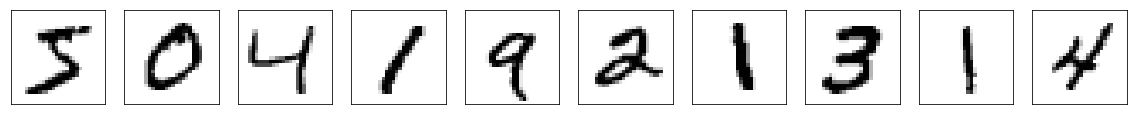

In [6]:
plot(x_train,None) # Non-noisy dataset

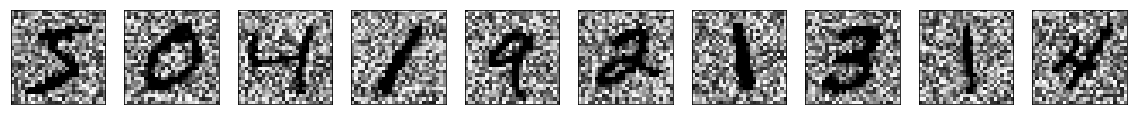

In [7]:
plot(x_train_noisy,None) #noisy data

## Task 4: Building and Training a Classifier
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [15]:
# classification mdoel with 2 hidden layers

classifier = Sequential([
    Dense(256,activation='relu',input_shape=(784,)),
    Dense(256,activation='relu'),
    Dense(10,activation='softmax')
])

classifier.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', # as we donot have one hot key encoding
    metrics = ['accuracy']
)

classifier.fit(x_train,y_train,batch_size=512,epochs=15)

Epoch 1/15
60000/60000 [==============================] - 5s 90us/step - loss: 0.4329 - acc: 0.8823
Epoch 2/15
60000/60000 [==============================] - 5s 80us/step - loss: 0.1588 - acc: 0.9537
Epoch 3/15
60000/60000 [==============================] - 5s 88us/step - loss: 0.1073 - acc: 0.9688
Epoch 4/15
60000/60000 [==============================] - 5s 83us/step - loss: 0.0789 - acc: 0.9769
Epoch 5/15
60000/60000 [==============================] - 4s 72us/step - loss: 0.0606 - acc: 0.9819
Epoch 6/15
60000/60000 [==============================] - 5s 76us/step - loss: 0.0463 - acc: 0.9864
Epoch 7/15
60000/60000 [==============================] - 4s 70us/step - loss: 0.0371 - acc: 0.9892
Epoch 8/15
60000/60000 [==============================] - 5s 75us/step - loss: 0.0296 - acc: 0.9919
Epoch 9/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0241 - acc: 0.9935
Epoch 10/15
60000/60000 [==============================] - 5s 76us/step - loss: 0.0189 - acc: 0.9948

In [16]:
#check its performance on its test dataset
loss,acc = classifier.evaluate(x_test,y_test)
print(acc) #good accuracy near to trainign dataset to check overfitting

10000/10000 [==============================] - 2s 167us/step
0.9814


In [17]:
#with noisy dataset
loss,acc = classifier.evaluate(x_test_noisy,y_test)
print(acc) #good accuracy near to trainign dataset to check overfitting

10000/10000 [==============================] - 1s 125us/step
0.3487


The classifier didnot work noisy data at all and very low accuracy. The reason we train our data on non-noisy data and evaluate on noisy test dataset is as we don't know noise in real live projects and we rely on existing data (which is non-noisy most of the time). Here we introduce noise artificially to understand the conept of AE

## Task 5: Building the Autoencoder
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [20]:
#Build AE to denoise the noise and see the accuracy afterwards
#if one or more hidden layer has less nodes as comapred to input/output then
# the training process will force the network to learn similar to PCA (reducing dimensionality)
# and also extract important features to perform de-noise of noisy data

input_image = Input(shape=(784,))
encoded = Dense(64,activation='relu')(input_image) #for encoding step , enforce dimension reduction

decoded = Dense(784, activation='sigmoid')(encoded) #back to 784 values

#De-noise means remvoing unwanted features needed to reconstruct the input
# Now we need to see on autoencoder model

autoencoder = Model(input_image,decoded)
autoencoder.compile(loss='binary_crossentropy',optimizer='adam')


## Task 6: Training the Autoencoder
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [24]:
# by training our autoencoder, out network will recognize important features and exclude noisy levels or unwanted features

autoencoder.fit(
    x_train_noisy,x_train,epochs=100,
    batch_size=512, validation_split=0.2,verbose=False,
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=5),
        LambdaCallback(on_epoch_end = lambda e,l:print('{:.3f}'.format(l['val_loss']),end='_'))
    ]
)

0.259_0.224_0.199_0.182_0.169_0.160_0.153_0.146_0.141_0.136_0.132_0.129_0.126_0.124_0.122_0.120_0.118_0.117_0.115_0.114_0.113_0.112_0.111_0.110_0.110_0.109_0.108_0.108_0.108_0.107_0.107_0.107_0.106_0.106_0.106_0.106_0.106_0.106_0.106_0.106_0.105_0.106_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_0.105_

## Task 7: Denoised Images
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [25]:
#pass noisy data through autoencoder
predictions = autoencoder.predict(x_test_noisy)

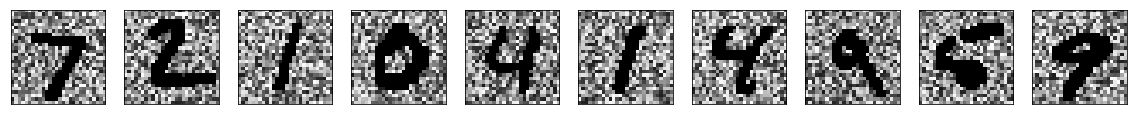

In [27]:
plot(x_test_noisy,None)

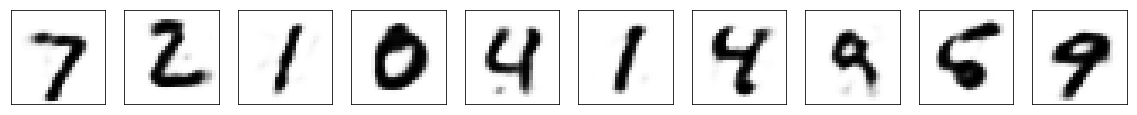

In [28]:
plot(predictions,None) # was to able denoise and predict and reconstruct the image

In [29]:
#how it looks with classifier
loss,acc = classifier.evaluate(predictions,y_test)
print(acc)

10000/10000 [==============================] - 1s 121us/step
0.963


Now we see rhe performance from our autoencoder. Now the accuracy is around 96% as before autoencoder it was around 34%. and the predicted images (re-constructed images) are well same as input noisy data


## Task 8: Composite Model
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [30]:
#Hook up our classifier and autoencoder together (composite model to have complete pipeline)

input_image = Input(shape=(784,))
x=autoencoder(input_image)
y=classifier(x)

denoise_and_classify = Model(input_image,y) # creation of denoise and classifier model

In [31]:
predictions = denoise_and_classify.predict(x_test_noisy) #predictions

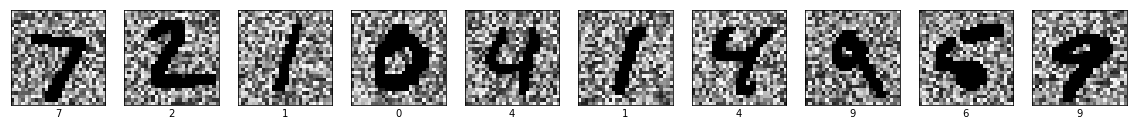

In [32]:
plot(x_test_noisy,predictions,True) # only one is mislabeled

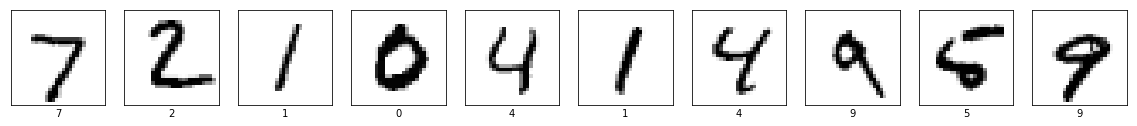

In [33]:
plot(x_test,to_categorical(y_test),True)

Only one term here that is 5 predicted as 6 in ten digits printed using denoise and classify model else everything seems to be well predicted 